In [1]:
import os

import pandas as pd

from tqdm.notebook import tqdm

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from PIL import Image

import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

#Download Dataset

In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/soumikrakshit/nyu-depth-v2'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ankithr02
Your Kaggle Key: ··········


100%|██████████| 4.10G/4.10G [01:55<00:00, 38.3MB/s]

#Prepare Dataset

In [30]:
class DepthDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform1, transform2):
        self.csv_file = csv_file
        self.root_dir = root_dir
        self.transform1 = transform1
        self.transform2 = transform2

    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.csv_file.iloc[index, 0])
        image = Image.open(img_path).convert('RGB')
        depth_path = os.path.join(self.root_dir, self.csv_file.iloc[index, 1])
        depth_map = Image.open(depth_path).convert('L')

        image = self.transform1(image)
        depth_map = self.transform2(depth_map)

        return image, depth_map

In [31]:
train_dir = '/content/nyu-depth-v2/nyu_data'
test_dir = '/content/nyu-depth-v2/nyu_data'

train_csv = pd.read_csv('/content/nyu-depth-v2/nyu_data/data/nyu2_train.csv')
train_csv = train_csv[:50560]
test_csv = pd.read_csv('/content/nyu-depth-v2/nyu_data/data/nyu2_test.csv')
test_csv = test_csv[:640]

In [32]:
image_size = (228, 304)
depth_map_size = (55, 74)
batch_size = 128

In [33]:
transform_img = transforms.Compose([transforms.Resize(image_size),
                          transforms.CenterCrop(image_size),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_depth = transforms.Compose([transforms.Resize(depth_map_size),
                          transforms.CenterCrop(depth_map_size),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5), (0.5))])

In [34]:
train_ds = DepthDataset(train_csv, train_dir, transform_img, transform_depth)
test_ds = DepthDataset(test_csv, test_dir, transform_img, transform_depth)

In [35]:
len(train_ds), len(test_ds)

(50560, 640)

In [36]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)

In [37]:
len(train_dl), len(test_dl)

(395, 5)

#Visualize Examples

In [38]:
stats_img = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
stats_dmaps = (0.5), (0.5)

In [39]:
def denorm1(img_tensors):
    return img_tensors * stats_img[1][0] + stats_img[0][0]

def denorm2(dmap_tensors):
    return dmap_tensors * stats_dmaps[1] + stats_dmaps[0]

In [40]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm1(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_dmaps(depth_maps, nmax=64):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm2(depth_maps.detach()[:nmax]), nrow=8).permute(1, 2, 0), cmap='gray')

def show_batch(dl, nmax=64):
    for images, depth_maps in dl:
        show_images(images, nmax)
        show_dmaps(depth_maps, nmax)
        break

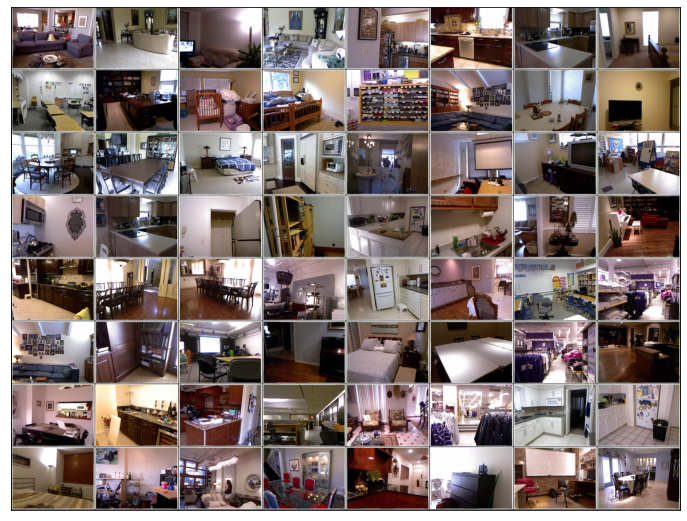

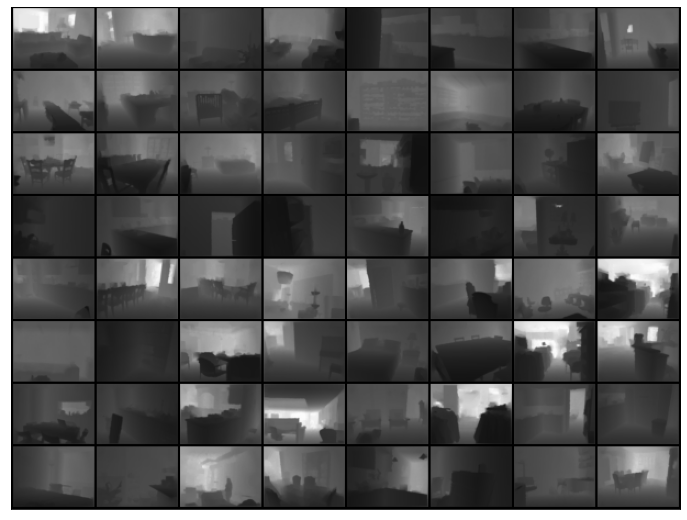

In [41]:
show_batch(train_dl)

#Device

In [42]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [43]:
device = get_default_device()
device

device(type='cuda')

#Global Coarse-Scale Network

In [44]:
class CoarseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # in: 3 x 228 x 304

            nn.Conv2d(3, 96, kernel_size = 11, stride = 4),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # out: 96 x 27 x 37

            nn.Conv2d(96, 256, kernel_size = 5, padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # out: 256 x 13 x 18

            nn.Conv2d(256, 384, kernel_size = 3, padding = 1),
            nn.ReLU(),
            # out: 384 x 13 x 18

            nn.Conv2d(384, 384, kernel_size = 3, padding = 1),
            nn.ReLU(),
            # out: 384 x 13 x 18

            nn.Conv2d(384, 256, kernel_size = 3, stride = 2),
            nn.ReLU(),
            # out: 256 x 6 x 8

            nn.Flatten(1, 3),
            nn.Linear(256*6*8, 4096),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(4096, 4070)
        )

    def forward(self, img):
        coarse = self.network(img)
        return torch.reshape(coarse, (batch_size, 1, 55, 74))

In [19]:
coarse_model = CoarseNetwork()

#Local Fine-Scale Network

In [45]:
class FineNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.network1 = nn.Sequential(
            # in: 3 x 304 x 228

            nn.Conv2d(3, 63, kernel_size = 9, stride = 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # out: 63 x 74 x 55  
        )
        self.network2 = nn.Sequential(
            # in: 64 x 74 x 55

            nn.Conv2d(64, 64, kernel_size = 5, padding = 2),
            nn.ReLU(),
            # out: 64 x 74 x55

            nn.Conv2d(64, 1, kernel_size = 5, padding = 2)
            # out: 1 x 74 x 55
        )
            
    def forward(self, img, coarse):
        fine = self.network1(img)
        fine = torch.cat((fine, coarse), dim = 1)
        return self.network2(fine)

In [46]:
fine_model = FineNetwork()

#Loss Function

In [47]:
n = 74 * 55

In [48]:
def train_loss(pred, output):
    pred = F.normalize(pred, dim=0)
    output = F.normalize(output, dim=0)

    # print(pred.mean(),output.mean())
    denorm = transforms.Normalize((-1), (1/128))
    pred = denorm(pred)
    output = denorm(output)
    # print(pred.mean(),output.mean())

    di = torch.log(pred) - torch.log(output)
    di2 = torch.square(di)

    loss = torch.sum(di2/n, (1, 2, 3)) - torch.square(torch.sum(di/n, (1, 2, 3)))
    return loss.mean()

In [49]:
pred = torch.randn(64, 1, 74, 55)
output = torch.randn(64, 1, 74, 55)
train_loss(pred, output), nn.MSELoss()(pred, output)

(tensor(0.0326), tensor(2.0065))

In [50]:
def scale_invariant_error(pred, output):
    pred = F.normalize(pred, dim=0)
    output = F.normalize(output, dim=0)

    denorm = transforms.Normalize((-1), (1/128))
    pred = denorm(pred)
    output = denorm(output)

    di = torch.log(pred+1) - torch.log(output+1)
    di2 = torch.square(di)

    error = torch.sum(di2/n, (1, 2, 3)) - torch.square(torch.sum(di/n, (1, 2, 3)))
    return error.mean()

#Training The Coarse Network

In [51]:
epochs = 10
lr = 0.0001

In [52]:
def train_coarse(epochs, lr, coarse_model, train_dl, opt_func = torch.optim.Adam):
    optimizer = opt_func(coarse_model.parameters(), lr)

    # Load the model into the GPU
    coarse_model = coarse_model.to(device)

    coarse_model.train()

    for epoch in range(epochs):
        coarse_losses = []
        for imgs, dmaps in tqdm(train_dl):

            # Move data into the GPU
            imgs = imgs.to(device)
            dmaps = dmaps.to(device)
            preds = coarse_model(imgs)

            loss = train_loss(preds, dmaps)
            coarse_losses.append(loss)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            torch.cuda.empty_cache()

        coarse_losses = torch.Tensor(coarse_losses)
        avg_loss = torch.mean(coarse_losses)
        print('Loss: ' + str(avg_loss))

In [53]:
train_coarse(epochs, lr, coarse_model, train_dl)

  0%|          | 0/395 [00:00<?, ?it/s]

Loss: tensor(0.0008)


  0%|          | 0/395 [00:00<?, ?it/s]

Loss: tensor(0.0004)


  0%|          | 0/395 [00:00<?, ?it/s]

Loss: tensor(0.0003)


  0%|          | 0/395 [00:00<?, ?it/s]

Loss: tensor(0.0002)


  0%|          | 0/395 [00:00<?, ?it/s]

Loss: tensor(0.0002)


  0%|          | 0/395 [00:00<?, ?it/s]

Loss: tensor(0.0002)


  0%|          | 0/395 [00:00<?, ?it/s]

Loss: tensor(0.0002)


  0%|          | 0/395 [00:00<?, ?it/s]

Loss: tensor(0.0002)


  0%|          | 0/395 [00:00<?, ?it/s]

Loss: tensor(0.0001)


  0%|          | 0/395 [00:00<?, ?it/s]

Loss: tensor(0.0001)


#Training The Fine Network

In [54]:
def train_fine(epochs, lr, fine_model, train_dl, opt_func = torch.optim.Adam):
    optimizer = opt_func(fine_model.parameters(), lr)

    # Load the model into the GPU
    fine_model = fine_model.to(device)

    fine_model.train()
    coarse_model.eval()

    for epoch in range(epochs):
        fine_losses = []
        for imgs, dmaps in tqdm(train_dl):

            # Move data into the GPU
            imgs = imgs.to(device)
            dmaps = dmaps.to(device)

            coarse_outputs = coarse_model(imgs)
            coarse_outputs = coarse_outputs.to(device)

            preds = fine_model(imgs, coarse_outputs)
            loss = train_loss(preds, dmaps)

            fine_losses.append(loss)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            torch.cuda.empty_cache()

        fine_losses = torch.Tensor(fine_losses)
        avg_loss = torch.mean(fine_losses)
        print('Loss: ' + str(avg_loss))

In [55]:
train_fine(epochs, lr, fine_model, train_dl)

  0%|          | 0/395 [00:00<?, ?it/s]

Loss: tensor(0.0008)


  0%|          | 0/395 [00:00<?, ?it/s]

Loss: tensor(0.0002)


  0%|          | 0/395 [00:00<?, ?it/s]

Loss: tensor(0.0001)


  0%|          | 0/395 [00:00<?, ?it/s]

Loss: tensor(0.0001)


  0%|          | 0/395 [00:00<?, ?it/s]

Loss: tensor(0.0001)


  0%|          | 0/395 [00:00<?, ?it/s]

Loss: tensor(0.0001)


  0%|          | 0/395 [00:00<?, ?it/s]

Loss: tensor(0.0001)


  0%|          | 0/395 [00:00<?, ?it/s]

Loss: tensor(0.0001)


  0%|          | 0/395 [00:00<?, ?it/s]

Loss: tensor(0.0001)


  0%|          | 0/395 [00:00<?, ?it/s]

Loss: tensor(0.0001)


In [63]:
torch.save(fine_model, 'model_fine.pt')

In [66]:
# torch.save(coarse_model,'model_coarse.pt')

#Results

In [67]:
def evaluate(coarse_model, fine_model, test_dl):
    errors = []
    si_errors = []
    rmse_errors = []

    for imgs, dmaps in tqdm(test_dl):
        imgs = imgs.to(device)
        dmaps = dmaps.to(device)

        coarse_outputs = coarse_model(imgs)
        preds = fine_model(imgs, coarse_outputs)

        error = train_loss(preds, dmaps)
        si_error = scale_invariant_error(preds, dmaps)
        rmse_error = torch.sqrt(nn.MSELoss()(preds, dmaps))

        errors.append(error)
        si_errors.append(si_error)
        rmse_errors.append(rmse_error)

    errors = torch.Tensor(errors)
    si_errors = torch.Tensor(si_errors)
    rmse_errors = torch.Tensor(rmse_errors)

    avg_error = torch.mean(errors)
    avg_si_error = torch.mean(si_errors)
    avg_rmse_error = torch.mean(rmse_errors)

    print('error: {}, scale invariant error: {}, root mean squared error: {}'.format(avg_error, avg_si_error, avg_rmse_error))

In [68]:
evaluate(coarse_model, fine_model, test_dl)

  0%|          | 0/5 [00:00<?, ?it/s]

error: 0.000599625171162188, scale invariant error: 0.0005898079252801836, root mean squared error: 1.2049520015716553


  0%|          | 0/5 [00:00<?, ?it/s]

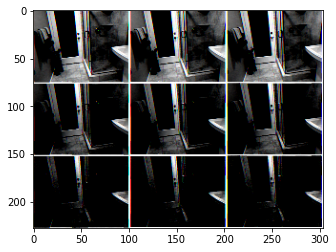

In [77]:
for imgs, dmaps in tqdm(test_dl):
  img0 = imgs.to(device)
  break

img0 = img0.to(device)
coarse0 = coarse_model(img0)

test_image = torch.squeeze(img0[0]).cpu().detach().numpy()
plt.imshow(test_image.reshape((228,304,3)))
plt.show()

In [78]:
img0.shape,coarse0.shape

(torch.Size([128, 3, 228, 304]), torch.Size([128, 1, 55, 74]))

In [79]:
fine0 = fine_model(img0, coarse0)

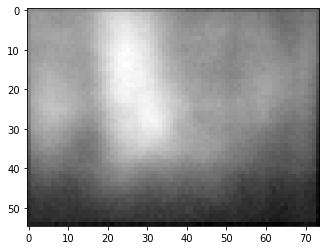

In [80]:
coarse_out = torch.squeeze(coarse0[0]).cpu().detach().numpy()
plt.imshow(coarse_out, cmap='gray')
plt.show()

In [81]:
torch.squeeze(coarse0[0]).shape

torch.Size([55, 74])

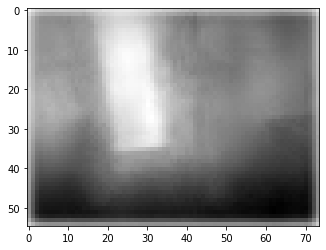

In [82]:
fine_out = torch.squeeze(fine0[0]).cpu().detach().numpy()
plt.imshow(fine_out,cmap='gray')
plt.show()